# Imports 

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Loading Data and Preprocessing

In [3]:
df = pd.read_csv('student-por.csv', delimiter=';')


In [4]:
df = df.replace({'Mjob': {'at_home': 0, 'teacher': 1, 'services': 2, 'health': 3, 'other': 4}})
df = df.replace({'G3': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}})
df = df.replace({'G3': {10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1}})



In [5]:
from sklearn.model_selection import GridSearchCV

feature_cols = ['G1', 'G2', 'absences', 'Mjob', 'goout']
# feature_cols = ['G1','G2','Mjob']
# feature_cols = ['G2']


X = df[feature_cols]
y = df['G3']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=21)


## Decision Tree

In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report

# add ccp_alpha from 0-1 (0.1, 0.01, 0.001)
dt = DecisionTreeClassifier(criterion='gini', max_depth=2, ccp_alpha=0.01)



dt.fit(X_train, y_train)
train_acc = dt.predict(X_train)
y_pred = dt.predict(X_test)
print(classification_report(train_acc, y_train))
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.64      0.95      0.76        55
           1       0.99      0.93      0.96       431

    accuracy                           0.93       486
   macro avg       0.82      0.94      0.86       486
weighted avg       0.95      0.93      0.94       486

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        18
           1       0.97      0.97      0.97       145

    accuracy                           0.94       163
   macro avg       0.85      0.87      0.86       163
weighted avg       0.95      0.94      0.95       163



### Lime

In [8]:
from interpret.blackbox import LimeTabular
from interpret import show

lime = LimeTabular(model=dt, 
                   data=X_train, 
                   random_state=1)

In [9]:
lime_local = lime.explain_local(X_test[-30:],
                               y_test[-30:],
                               name='LIME')
show(lime_local)

<!-- http://127.0.0.1:7700/2713350692048/ -->

### Shapley Values

### Results for Feature Set 1:

Optimal Hyperparameters -> criterion='gini', max_depth=2

Classification Report (weighted avg) -> precision=0.93, recall=0.92, f1=0.92

### Results for Feature Set 2

Optimal Hyperparameters -> criterion='gini', max_depth=2

Classification Report (weighted avg) -> precision=0.92, recall=0.91, f1=0.91

### Results for Feature Set 3

Optimal Hyperparameters -> criterion='gini', max_depth=default

Classification Report (weighted avg) -> precision=0.93, recall=0.92, f1=0.92

In [124]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

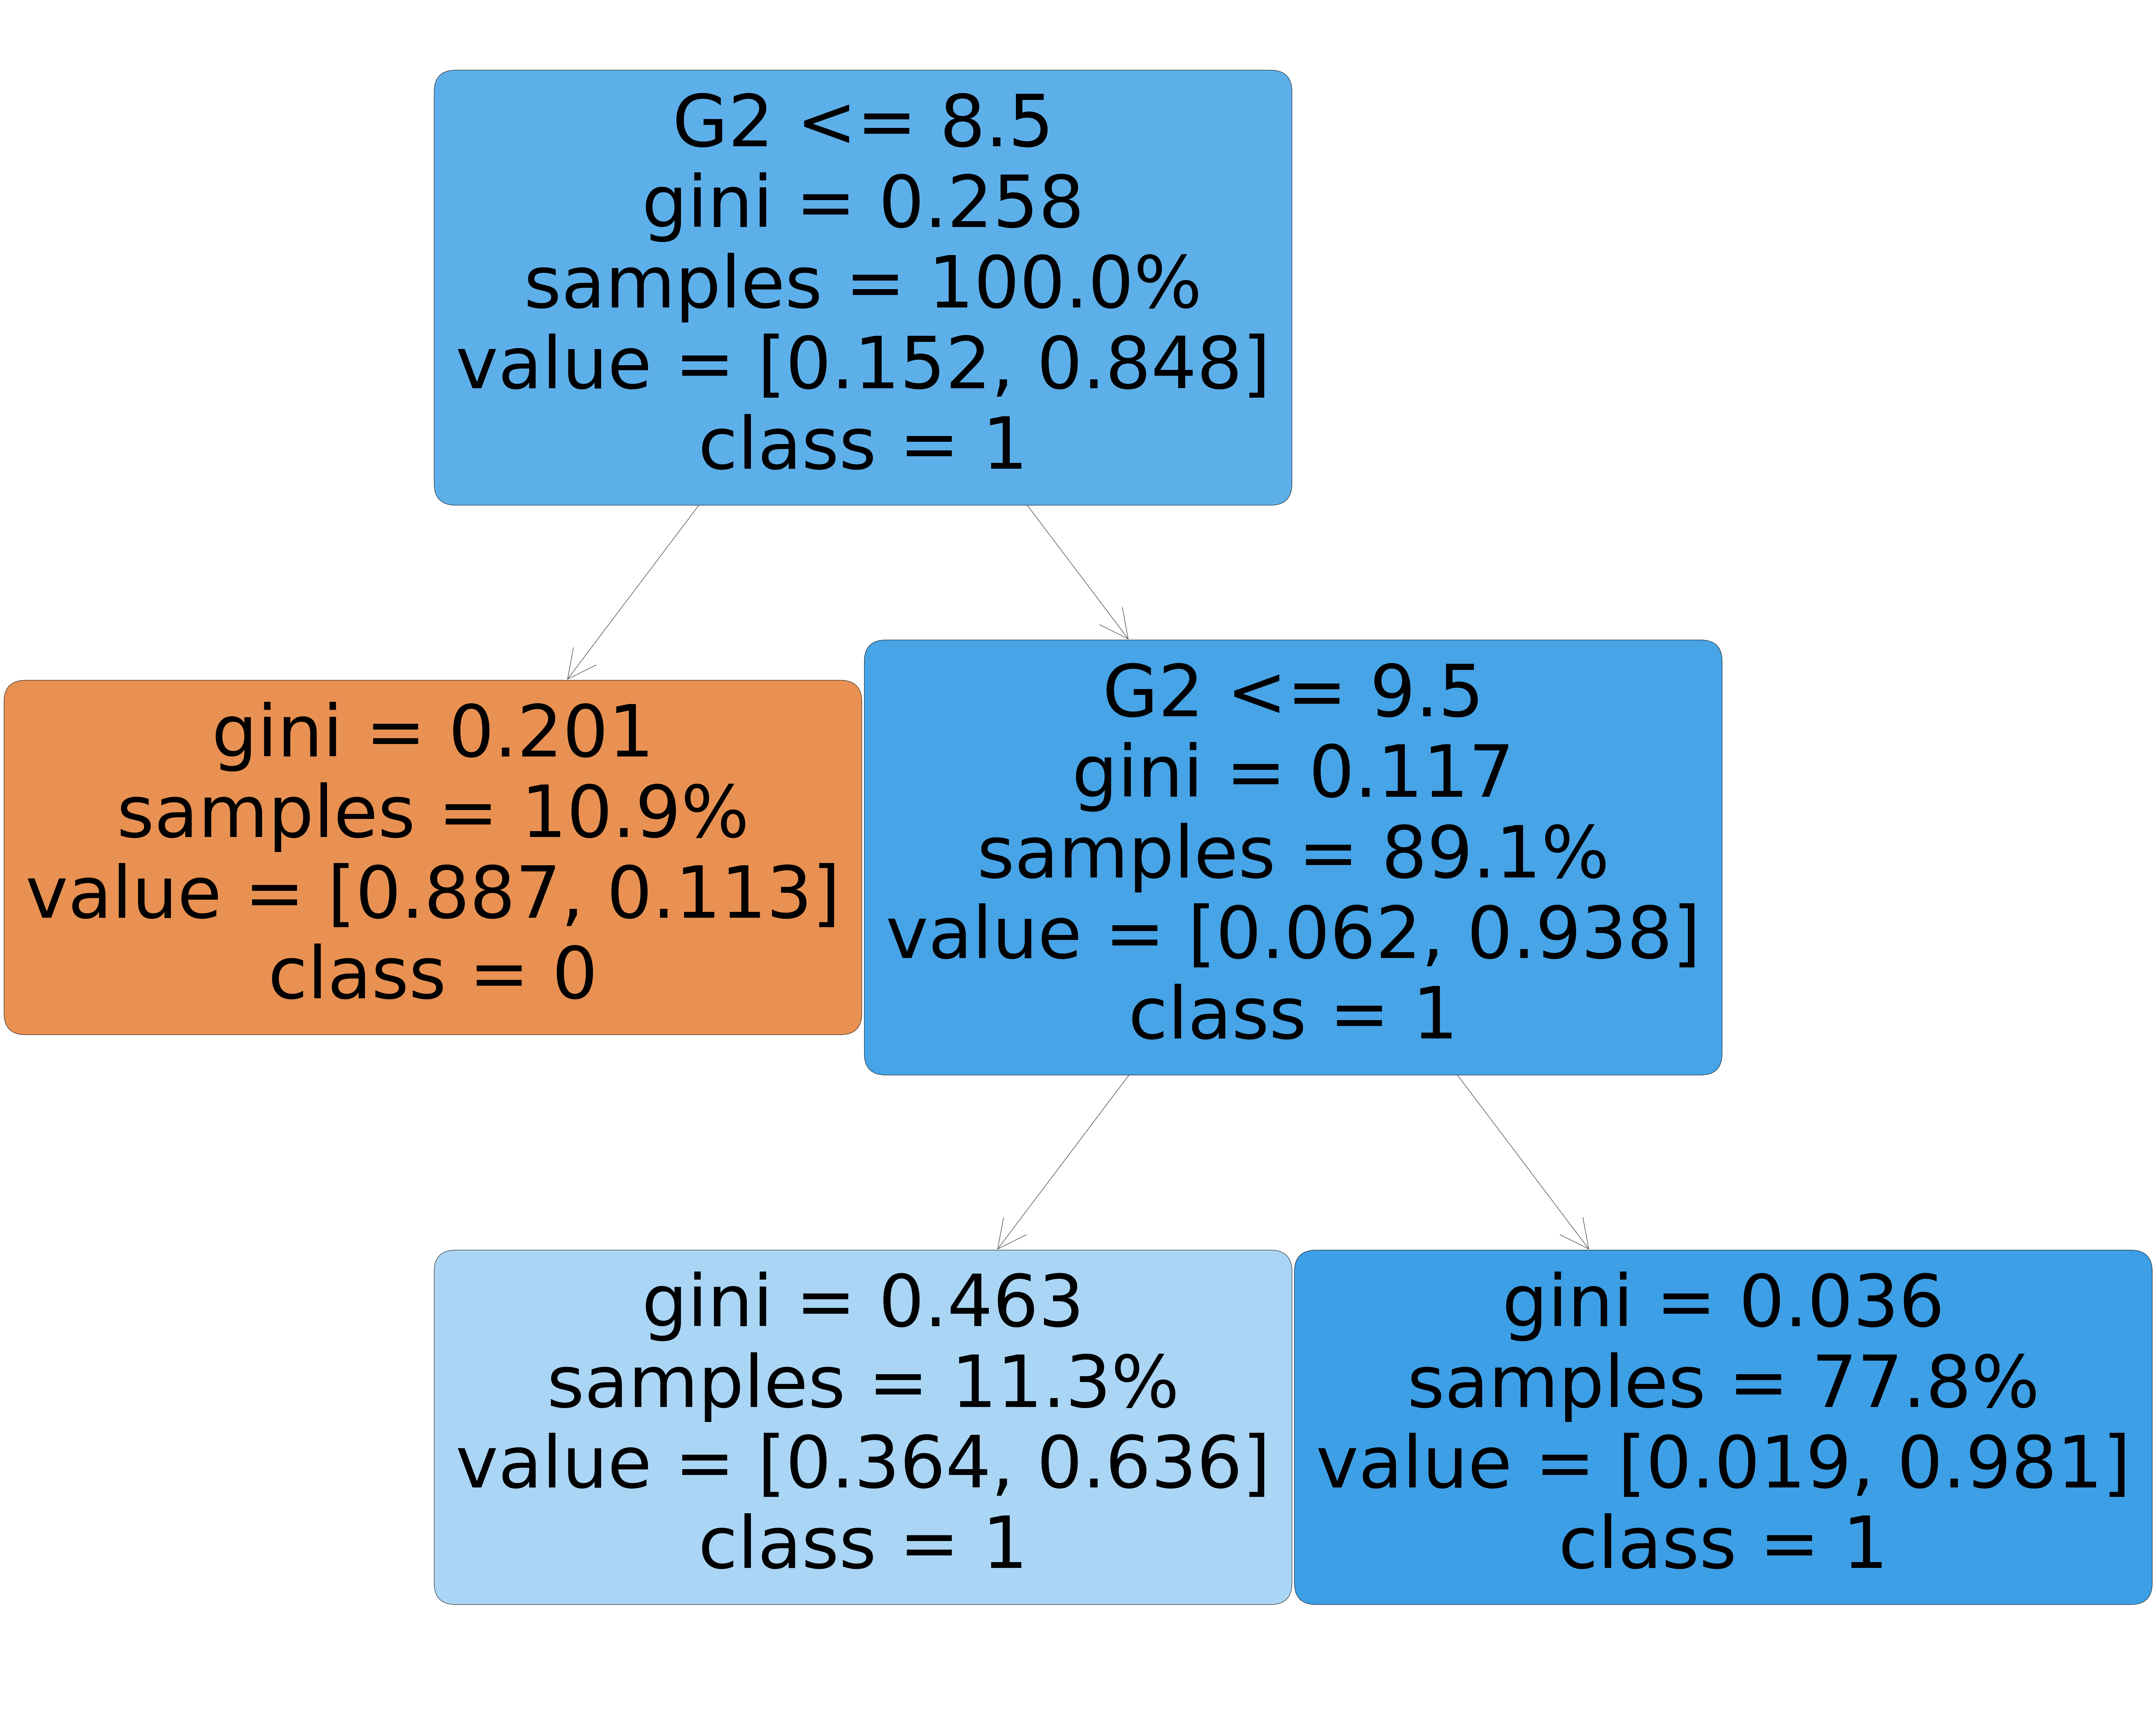

In [125]:
from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
plt.figure(figsize=(100, 80))
plot_tree(dt,
          feature_names=feature_cols,
          class_names=['0','1'],
          rounded=True, # Rounded node edges
          filled=True, # Adds color accoding to class
          proportion=True)
plt.show()

## Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

# ccp_alpha try here also
rf = RandomForestClassifier(n_estimators=200, criterion='gini', max_depth=3, ccp_alpha=0.01)

rf.fit(X_train, y_train)

train_acc_rf = rf.predict(X_train)

y_pred_2 = rf.predict(X_test)


In [14]:
print(metrics.classification_report(y_train, train_acc_rf))
print(metrics.classification_report(y_test, y_pred_2))


              precision    recall  f1-score   support

           0       0.95      0.64      0.76        81
           1       0.93      0.99      0.96       405

    accuracy                           0.93       486
   macro avg       0.94      0.82      0.86       486
weighted avg       0.93      0.93      0.93       486

              precision    recall  f1-score   support

           0       0.78      0.74      0.76        19
           1       0.97      0.97      0.97       144

    accuracy                           0.94       163
   macro avg       0.87      0.85      0.86       163
weighted avg       0.94      0.94      0.94       163



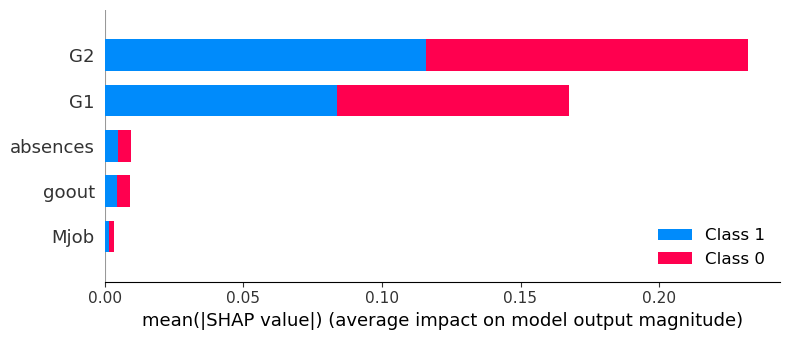

In [19]:
# SHAP exlanation force plots
import shap

# explanation using shap values
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [128]:
rf.feature_importances_

array([0.45386   , 0.4750807 , 0.03188992, 0.01911317, 0.02005621])

Built-In Feature Importance 

Text(0.5, 0, 'Random Forest Feature Importance')

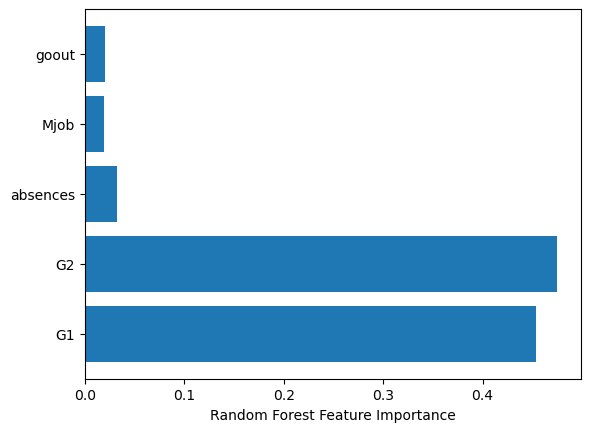

In [129]:
plt.barh(feature_cols, rf.feature_importances_)
plt.xlabel("Random Forest Feature Importance")

Permutation Based Feature Importance

In [130]:
from sklearn.inspection import permutation_importance 

perm_importance = permutation_importance(rf, X_test, y_test)


Text(0.5, 0, 'Random Forest Feature Importance')

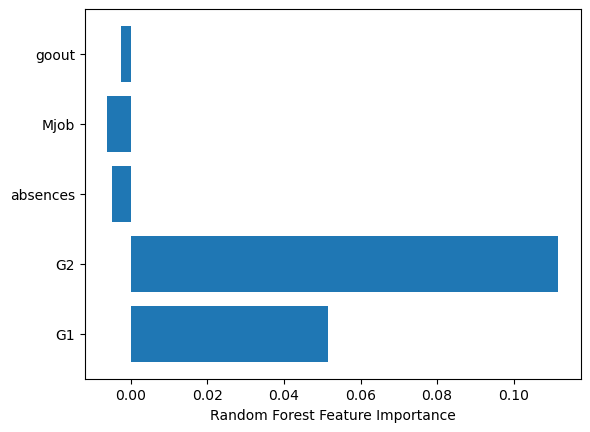

In [131]:
plt.barh(feature_cols, perm_importance.importances_mean)
plt.xlabel("Random Forest Feature Importance")

SHAP Feature Importance

In [205]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)


ImportError: Numba needs NumPy 1.21 or less

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [ ]:
shap.summary_plot(shap_values, X_test)


### Results for Feature Set 1:

Optimal Hyperparameters -> n_estimators=100, criterion='gini', max_depth=3

Classification Report (weighted avg) -> precision=0.92, recall=0.92, f1=0.92



In [ ]:
plt.figure(figsize=(100, 80))
plot_tree(rf.estimators_[5],
          feature_names=feature_cols,
          class_names=['0','1'],
          rounded=True, # Rounded node edges
          filled=True, # Adds color accoding to class
          proportion=True)
plt.show()

### Performing LIME On Random Forest

In [ ]:

from interpret.blackbox import LimeTabular
from interpret import show

predict_fn_rf = lambda x: rf.predict_proba(X_test).astype(float)

In [ ]:
lime = LimeTabular(model=rf, 
                   data=X_train, 
                   random_state=1)

In [ ]:
lime_local = lime.explain_local(X_test[-30:],
                               y_test[-30:],
                               name='LIME')

In [ ]:
show(lime_local)

## Learned Vector Quantization

In [141]:

from sklvq import GLVQ
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

model = GLVQ(
        distance_type="squared-euclidean",
    activation_type="swish",
    activation_params={"beta": 2},
    solver_type="adam",
    solver_params={"max_runs": 20, "step_size": 0.1},
)



In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.25)

In [ ]:
model.fit(X2_train, y2_train)

In [ ]:
y_pred_3 = model.predict(X2_test)
print(classification_report(y2_test, y_pred_3))

Visualizing Prototypes of LVQ

Returns model prototypes / quantized vectors as values in array

In [ ]:
model.get_model_params()

In [ ]:
model.get_params()

In [ ]:
model.get_prototypes()

In [ ]:
model.get_variables()

In [ ]:
# # Visualizing Prototypes
# colors = ["blue", "red",]
# num_prototypes = model.prototypes_.shape[0]
# num_features = model.prototypes_.shape[1]

# fig, ax = plt.subplots(num_prototypes, 1)
# fig.suptitle("Prototype of each class")

# for i, prototype in enumerate(model.prototypes_):
#     prototype = scaler.inverse_transform(prototype)
    
#     ax[i].bar(
#         range(num_features),
#         prototype,
#         color=colors[i],
#         label=y.iloc[model.prototypes_labels_[i]],
#     )
#     ax[i].set_xticks(range(num_features))
#     if i == (num_prototypes - 1):
#         ax[i].set_xticklabels([name[:-5] for name in X[feature_cols]])
#     else:
#         ax[i].set_xticklabels([], visible=False)
#         ax[i].tick_params(
#             axis="x", which="both", bottom=False, top=False, labelbottom=False
#         )
#     ax[i].set_ylabel("cm")
#     ax[i].legend()

# Neural Networks MLP

In [133]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mlp = MLPClassifier(hidden_layer_sizes=(6,5),
                    verbose=True,
                    activation='relu',
                    learning_rate_init=0.01)

In [136]:
mlp.fit(X_train, y_train)

Iteration 1, loss = 0.74625697
Iteration 2, loss = 0.48201713
Iteration 3, loss = 0.38529504
Iteration 4, loss = 0.41117352
Iteration 5, loss = 0.39045978
Iteration 6, loss = 0.34540041
Iteration 7, loss = 0.32887497
Iteration 8, loss = 0.32804236
Iteration 9, loss = 0.32198294
Iteration 10, loss = 0.30201310
Iteration 11, loss = 0.28864979
Iteration 12, loss = 0.28633833
Iteration 13, loss = 0.27969568
Iteration 14, loss = 0.27246849
Iteration 15, loss = 0.27050447
Iteration 16, loss = 0.26933595
Iteration 17, loss = 0.26224322
Iteration 18, loss = 0.25649232
Iteration 19, loss = 0.25526452
Iteration 20, loss = 0.24893149
Iteration 21, loss = 0.24816229
Iteration 22, loss = 0.24512424
Iteration 23, loss = 0.24096201
Iteration 24, loss = 0.23873527
Iteration 25, loss = 0.23561010
Iteration 26, loss = 0.23391820
Iteration 27, loss = 0.23350459
Iteration 28, loss = 0.22935583
Iteration 29, loss = 0.22922404
Iteration 30, loss = 0.22809004
Iteration 31, loss = 0.22612197
Iteration 32, los

MLPClassifier(hidden_layer_sizes=(6, 5), learning_rate_init=0.01, verbose=True)

In [137]:
y_pred_mlp = mlp.predict(X_test)

In [138]:
print(classification_report(y_pred_mlp, y_test))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        26
           1       0.96      0.96      0.96       137

    accuracy                           0.93       163
   macro avg       0.86      0.86      0.86       163
weighted avg       0.93      0.93      0.93       163



## Plotting Confidence Intervals for Models & Generating Probability Distributions

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=649-40, stratify=y)

In [145]:
classifier_list = [(dt, 'Decision Tree'), (rf, 'Random Forest'), (model, 'LVQ'), (mlp, 'MLP')]

C:\Users\Islam.Anwar\Anaconda3\envs\analytics\lib\site-packages\sklearn\calibration.py:1176: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.

C:\Users\Islam.Anwar\Anaconda3\envs\analytics\lib\site-packages\sklearn\calibration.py:1176: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.

C:\Users\Islam.Anwar\Anaconda3\envs\analytics\lib\site-packages\sklearn\calibration.py:1176: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.

C:\Users\Islam.Anwar\Anaconda3\envs\analytics\lib\site-packages\sklearn\calibration.py:1176: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument wil

Iteration 1, loss = 0.88463888
Iteration 2, loss = 0.84816960
Iteration 3, loss = 0.82357993
Iteration 4, loss = 0.80194651
Iteration 5, loss = 0.77200025
Iteration 6, loss = 0.74836598
Iteration 7, loss = 0.72272866
Iteration 8, loss = 0.69519216
Iteration 9, loss = 0.66781486
Iteration 10, loss = 0.63761837
Iteration 11, loss = 0.60531990
Iteration 12, loss = 0.57179630
Iteration 13, loss = 0.53770820
Iteration 14, loss = 0.50383389
Iteration 15, loss = 0.47106551
Iteration 16, loss = 0.44034818
Iteration 17, loss = 0.41268228
Iteration 18, loss = 0.38896142
Iteration 19, loss = 0.36987770
Iteration 20, loss = 0.35581615
Iteration 21, loss = 0.34677691
Iteration 22, loss = 0.34234945
Iteration 23, loss = 0.34175402
Iteration 24, loss = 0.34409918
Iteration 25, loss = 0.34861620
Iteration 26, loss = 0.35384838
Iteration 27, loss = 0.35884867
Iteration 28, loss = 0.36290038
Iteration 29, loss = 0.36554838
Iteration 30, loss = 0.36658686
Iteration 31, loss = 0.36601341
Iteration 32, los

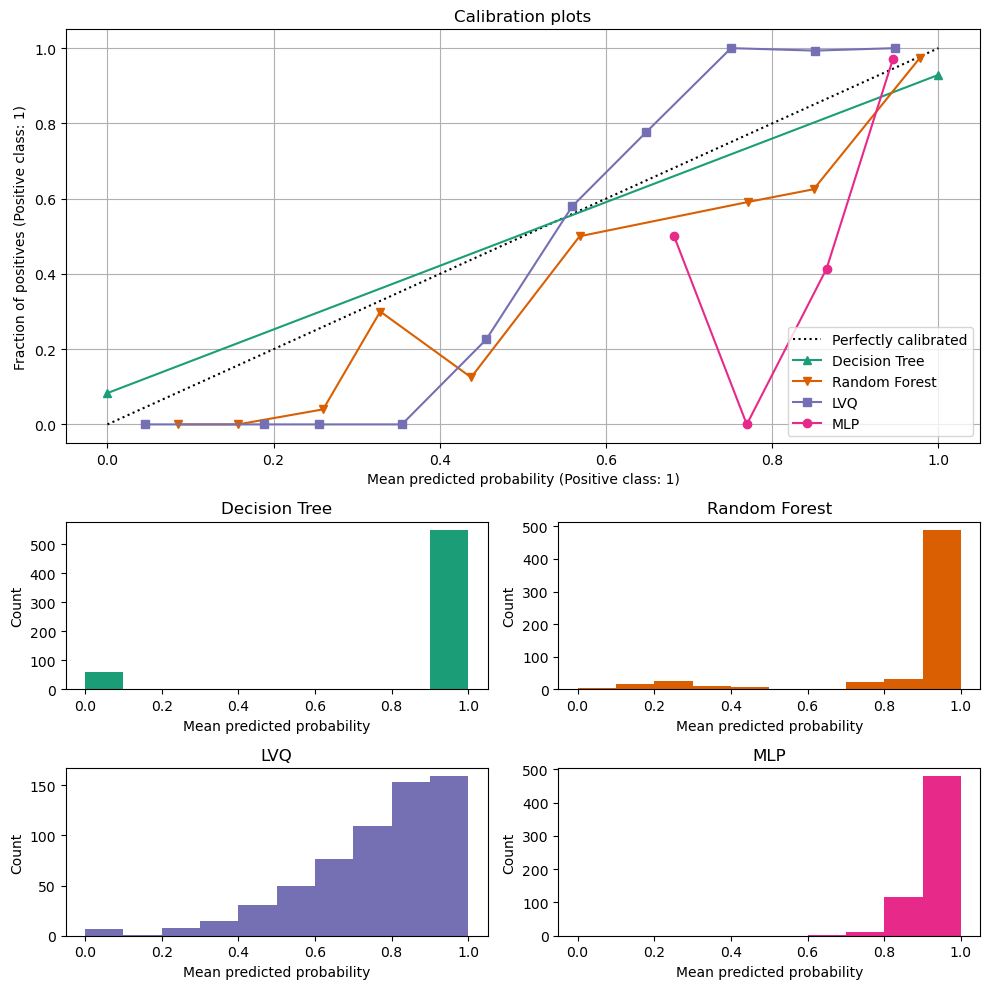

In [146]:
from sklearn.calibration import CalibrationDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train, y_train)
    display = sklearn.calibration.CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(classifier_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

# Confidence Intervals of Classifiers

Normal Approximation

In [157]:
import scipy.stats

confidence = 0.95 
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

1.959963984540054


In [160]:
# Training DT ONLY for now

dt.fit(X_train, y_train)

dt_acc = dt.score(X_test, y_test)
ci_length = z_value * np.sqrt((dt_acc * (1 - dt_acc)) / y_test.shape[0])

ci_lower = dt_acc - ci_length
ci_upper = dt_acc + ci_length

print(ci_lower, ci_upper)


0.9097223384136477 0.9798482137335915


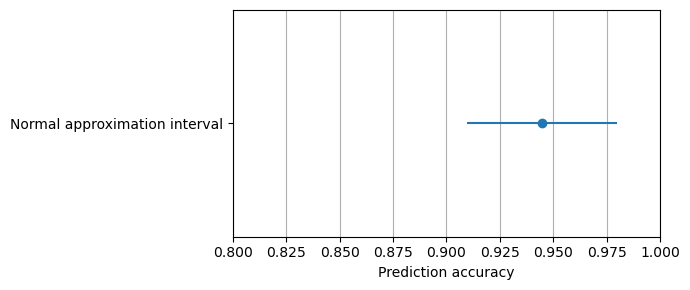

In [163]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.errorbar(dt_acc, 0, xerr=ci_length, fmt="o")

ax.set_xlim([0.8, 1.0])

ax.set_yticks(np.arange(1))
ax.set_yticklabels(["Normal approximation interval"])
ax.set_xlabel("Prediction accuracy")

plt.tight_layout()
plt.grid(axis="x")
plt.show()


results = {
    "Method 1: Normal approximation": {
        "Test accuracy": acc_test,
        "Lower 95% CI": ci_lower,
        "Upper 95% CI": ci_upper,
    }
}



Different random seeds using a t-distribution instead of z-standard normal distribution

In [180]:
test_accuracies = []
rounds = 3


for i in range(rounds):

    dt.fit(X_train, y_train)
    acc = dt.score(X_test, y_test)
    test_accuracies.append(acc)

test_mean = np.mean(test_accuracies)
test_mean


0.9447852760736196

In [181]:
confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=rounds - 1)

sd = np.std(test_accuracies, ddof=1)
se = sd / np.sqrt(rounds)

ci_length = t_value * se

ci_lower = test_mean - ci_length
ci_upper = test_mean + ci_length

print(ci_lower, ci_upper)


0.9447852760736196 0.9447852760736196


In [182]:
print('lower bound: {}'.format(ci_lower))
print(test_mean)
print('upper bound: {}'.format(ci_upper))

lower bound: 0.9447852760736196
0.9447852760736196
upper bound: 0.9447852760736196


# RuleCOSI

Used for combination and simplification of rulesets of machine learning classifiers

In [191]:
from rulecosi import RuleCOSIClassifier

In [194]:
rc = RuleCOSIClassifier(base_ensemble=rf, 
                        metric='precision',n_estimators=100, tree_max_depth=3, 
                        conf_threshold=0.95, cov_threshold=0.0, column_names=X_train.columns)

In [195]:
rc.fit(X_train, y_train)

RuleCOSIClassifier(base_ensemble=RandomForestClassifier(ccp_alpha=0.01,
                                                        max_depth=3),
                   column_names=Index(['G1', 'G2', 'absences', 'Mjob', 'goout'], dtype='object'),
                   conf_threshold=0.95, metric='precision', n_estimators=100)

In [196]:
rc.simplified_ruleset_.print_rules(heuristics_digits=4, condition_digits=1)

cov 	conf 	supp 	samples 		rule
0.7716	0.9653	0.7449	[13,362]	r_1: (G1 > 8.5) ˄ (G2 > 8.5) ˄ (absences ≤ 11.5) → [1]
0.0453	1.0000	0.0453	[0,22]		r_2: (G1 > 9.5) ˄ (G2 > 8.5) → [1]
0.1831	0.7640	0.1399	[68,21]		r_3: ( ) → [0]



In [197]:
rc.simplified_ruleset_.print_rules(return_object='dataframe',heuristics_digits=4, condition_digits=1)

,cov,conf,supp,samples,#,A,y
0,0.7716,0.9653,0.7449,"[13,362]",r_1,(G1 > 8.5) ˄ (G2 > 8.5) ˄ (absences ≤ 11.5),[1]
1,0.0453,1.0000,0.0453,"[0,22]",r_2,(G1 > 9.5) ˄ (G2 > 8.5),[1]
2,0.1831,0.7640,0.1399,"[68,21]",r_3,(),[0]


In [198]:
# this function is used for counting the number of rules extracted from the tree ensemble (original ruelesets)
def get_n_rules(rulesets):
    n_rules = 0
    for ruleset in rulesets:
        for rule in ruleset:
            n_rules += 1
    return n_rules

In [199]:
print(f'== Original Random Forest ensemble ==')
print(f'Number of trees: {rc.base_ensemble_.n_estimators} trees')
print(f'Number of rules: {get_n_rules(rc.original_rulesets_)} rules\n')


== Original Random Forest ensemble ==
Number of trees: 100 trees
Number of rules: 379 rules



In [204]:
print(f'== Simplified rules ==')
rc.simplified_ruleset_.print_rules()
y_pred = rc.predict(X_test)
if isinstance(rc.base_ensemble, RandomForestClassifier):
    y_pred_ens = rc.base_ensemble_.predict(X_test)
else:
    y_pred_ens = rc.base_ensemble_.predict(X_test)
print("Combinations: {}".format(rc.n_combinations_))
print("Time: {}\n".format(rc.combination_time_))
print(f'====== Classification performance of Random Forest ======')
print(classification_report(y_test, y_pred_ens,digits=4))
print(f'\n====== Classification performance of simplified rules ======')
print(classification_report(y_test, y_pred,digits=4))
print('\n')

== Simplified rules ==
cov 	conf 	supp 	samples 		rule
0.7716	0.9653	0.7449	[13,362]	r_1: (G1 > 8.500) ˄ (G2 > 8.500) ˄ (absences ≤ 11.500) → [1]
0.0453	1.0000	0.0453	[0,22]		r_2: (G1 > 9.500) ˄ (G2 > 8.500) → [1]
0.1831	0.7640	0.1399	[68,21]		r_3: ( ) → [0]

Combinations: 332
Time: 0.27012014389038086

====== Classification performance of Random Forest ======
              precision    recall  f1-score   support

           0     0.7895    0.7895    0.7895        19
           1     0.9722    0.9722    0.9722       144

    accuracy                         0.9509       163
   macro avg     0.8808    0.8808    0.8808       163
weighted avg     0.9509    0.9509    0.9509       163


====== Classification performance of simplified rules ======
              precision    recall  f1-score   support

           0     0.6800    0.8947    0.7727        19
           1     0.9855    0.9444    0.9645       144

    accuracy                         0.9387       163
   macro avg     0.8328    0.9

C:\Users\Islam.Anwar\Anaconda3\envs\analytics\lib\site-packages\sklearn\base.py:413: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names

